In [133]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import time
%matplotlib inline
import trap_util as tu
from trap_util import trap
from trap_util import quarter_trap
from trap_util import half_trap
import mysql.connector
import matplotlib.colors as colors
# physical parameters
q = -1.60217662e-19 # coulombs
m = 9.10938356e-31 #kg (electron)
#m = 6.6359437706294e-26 #(calcium)
kB = 1.38064852e-23 # J/K
f = 1.5e9 # Electrode frequency, in Hertz

In [18]:
from scipy.interpolate import RectBivariateSpline

## Trying on the actual electric field data

In [19]:
data = np.loadtxt("etrap_65V_1p5GHz_realsmoothExEy_2um.fld", skiprows = 2)

x_max =  2.0 mm
y_max =  2.0 mm
x_min =  -2.0 mm
y_min =  -2.0 mm
spatial resolution x:  2.0 um
spatial resolution y:  2.0 um
x       -0.002000
y       -0.002000
z        0.000000
Ex    1393.801039
Ey    -839.978074
Ez       0.000000
Name: 0, dtype: float64


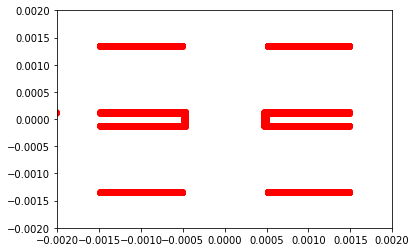

In [176]:
# manipulating E field data
df = pd.DataFrame(data, columns=['x', 'y', 'z', 'Ex', 'Ey', 'Ez'])
x_max, x_min = df.x.max(), df.x.min()
y_max, y_min = df.y.max(), df.y.min()
# print(x_max, x_min, y_max, y_min)
# print(df.y.nunique())
Nx, Ny = df.x.nunique() - 1, df.y.nunique() - 1 # numbers of intervals that divide each dimension
dx, dy = (x_max-x_min)/Nx, (y_max-y_min)/Ny # interval size
print("x_max = ", x_max*1.0e3, "mm")
print("y_max = ", y_max*1.0e3, "mm")
print("x_min = ", x_min*1.0e3, "mm")
print("y_min = ", y_min*1.0e3, "mm")
print("spatial resolution x: ", dx*1.0e6, "um")
print("spatial resolution y: ", dy*1.0e6, "um")

electrode = df.loc[(np.abs(df["Ex"]) < 1.0e-8) & (np.abs(df["Ey"]) < 1.0e-8)]
x_electrode = electrode.iloc[:, 0].values
y_electrode = electrode.iloc[:, 1].values
plt.plot(x_electrode, y_electrode, "r.")
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
print(df.iloc[0, :])

## Understanding how arrays manipulation (reshape, meshgrid) works

In [210]:
df.shape

(4004001, 6)

In [211]:
x = df['x'].values
y = df['y'].values
Ex = df['Ex'].values
Ex_matrix = Ex.reshape(Nx+1, Ny+1)
Ey = df['Ey'].values
Ey_matrix = Ey.reshape(Nx+1, Ny+1)
x_cdn = x.reshape(Nx+1, Ny+1)
y_cdn = y.reshape(Nx+1, Ny+1)
test = x_cdn+y_cdn

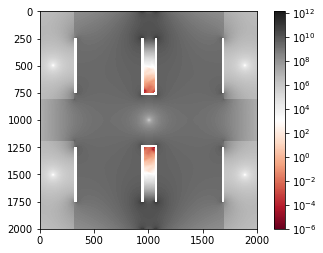

In [180]:
plt.imshow(Ex_matrix**2 + Ey_matrix**2, norm=colors.LogNorm(vmin=1.0e-6, vmax=1.3e12), cmap='RdGy')
plt.colorbar()
plt.axis(aspect='image');

In [212]:
x_arr = np.linspace(x_min, x_max, Nx+1)
y_arr = np.linspace(y_min, y_max, Ny+1)

In [216]:
intp_Ex = RectBivariateSpline(x_arr, y_arr, Ex_matrix, kx=1, ky=1)
intp_Ey = RectBivariateSpline(x_arr, y_arr, Ey_matrix, kx=1, ky=1)

In [217]:
def Ex_int(x, y):
    return intp_Ex(x, y)[0][0]
def Ey_int(x, y):
    return intp_Ey(x, y)[0][0]

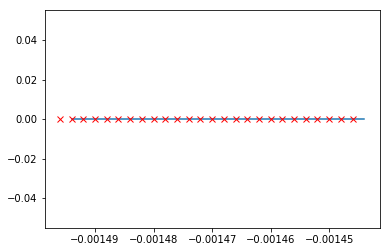

In [218]:
electrode = df.loc[(np.abs(df["Ex"]) < 1.0e-8) & (np.abs(df["Ey"]) < 1.0e-8)]
x_electrode = electrode.iloc[:, 0].values
y_electrode = electrode.iloc[:, 1].values
Ex_electrode = electrode.iloc[:, 3].values
Ey_electrode = electrode.iloc[:, 4].values
plot_df = electrode.loc[(abs(electrode['y']-0.000114)<1.0e-8) & (electrode['x']>-0.001498) & (electrode['x']<-0.001444)]
x_plot = np.linspace(-0.001494, -0.001444, 1000)
y_plot = []
for x in x_plot:
    y_plot.append(Ex_int(x, -0.000114))
plt.plot(x_plot, y_plot)
plt.plot(plot_df['x'].values, plot_df['Ex'].values, 'rx')

In [205]:
electrode.loc[(abs(electrode['y']-0.000114)<1.0e-8) & (electrode['x']>-0.001494) & (electrode['x']<-0.001444)]

,x,y,z,Ex,Ey,Ez
509311,-0.001492,0.000114,0.0,0.0,0.0,0.0
511312,-0.001490,0.000114,0.0,0.0,0.0,0.0
513313,-0.001488,0.000114,0.0,0.0,0.0,0.0
515314,-0.001486,0.000114,0.0,0.0,0.0,0.0
517315,-0.001484,0.000114,0.0,0.0,0.0,0.0
519316,-0.001482,0.000114,0.0,0.0,0.0,0.0
521317,-0.001480,0.000114,0.0,0.0,0.0,0.0
523318,-0.001478,0.000114,0.0,0.0,0.0,0.0
525319,-0.001476,0.000114,0.0,0.0,0.0,0.0
527320,-0.001474,0.000114,0.0,0.0,0.0,0.0


In [172]:
Ex_int

1393.801038781571

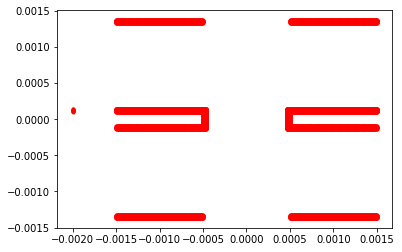

In [220]:
x_elt = []
y_elt = []
for xp in np.linspace(x_min, x_max, 1000):
    for yp in np.linspace(y_min, y_max, 1000):
        #print(intp_Ex(x,y)[0][0])
        #print(intp_Ex(xp, yp), )
        if np.sqrt(intp_Ex(xp, yp)[0][0]**2 + intp_Ey(xp, yp)[0][0]**2) < 1.0e-5:
            x_elt.append(xp)
            y_elt.append(yp)
plt.plot(x_elt, y_elt, 'r.')

In [88]:
x = 126.0e-6
y = 150.0e-6
intp(x, y)

array([[-12437.64103457]])

In [86]:
df.loc[(abs(df['x']-150.0e-6) <= 2.0e-6) & (abs(df['y']-126.0e-6) <= 2.0e-6)]

,x,y,z,Ex,Ey,Ez
2152138,0.000150,0.000126,0.0,-15385.319858,15143.027538,0.0
2154139,0.000152,0.000126,0.0,-15592.285443,15171.544723,0.0


### Tiny example of RectBivariateSpline

In [109]:
df1 = pd.DataFrame({'x': [0,0,0,1,1,1,2,2,2,3,3,3], 'y': [100,110,120,100,110,120, 100,110,120, 100,110,120]})
phi = df1.x.values + 4*df1.y.values
df1['phi'] = phi
df1

,x,y,phi
0,0,100,400
1,0,110,440
2,0,120,480
3,1,100,401
4,1,110,441
5,1,120,481
6,2,100,402
7,2,110,442
8,2,120,482
9,3,100,403


In [111]:
phi_matrix = df1['phi'].values.reshape(4, 3)
x1_arr = np.array([0,1,2,3])
y1_arr = np.array([100, 110, 120])

In [112]:
print(x1_arr)
print(y1_arr)
print(phi_matrix)

[0 1 2 3]
[100 110 120]
[[400 440 480]
 [401 441 481]
 [402 442 482]
 [403 443 483]]


In [115]:
intp = RectBivariateSpline(x1_arr, y1_arr, phi_matrix, kx=2, ky=2)

In [119]:
intp(2.5, 113.7)

array([[457.3]])